#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 5 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

In [1]:
import sys
!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From: https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
To: /home/jupyter/week 5/IT_data.h5
100%|██████████| 384M/384M [00:01<00:00, 221MB/s]  


'IT_data.h5'

### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


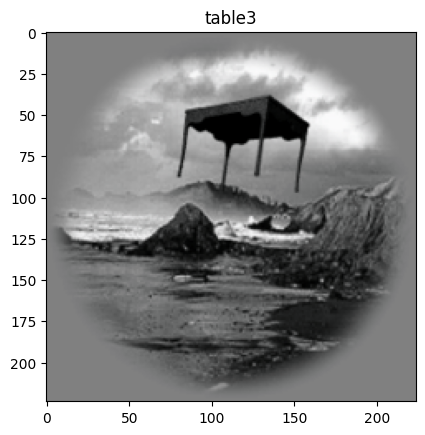

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

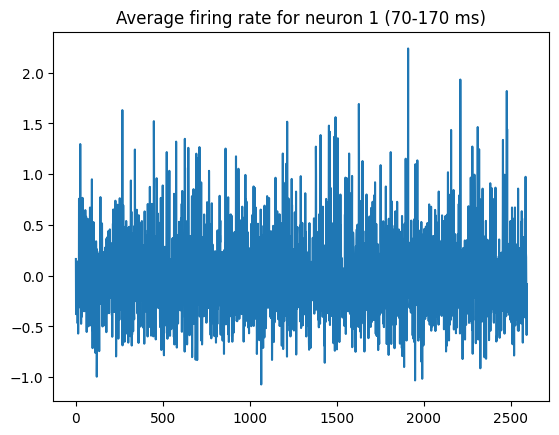

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## import packtages and explore data

In [7]:
from sklearn import linear_model
from sklearn import metrics as ms
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [8]:
stimulus_train.shape

(2592, 3, 224, 224)

In [9]:
stimulus_test.shape

(320, 3, 224, 224)

In [10]:
stimulus_val.shape

(288, 3, 224, 224)

In [11]:
spikes_train.shape

(2592, 168)

In [12]:
spikes_val.shape

(288, 168)

# Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

## 0: data processing

In [13]:
#reshape the data 

X_train = stimulus_train.reshape(2592, 3*224*224) 
y_train = spikes_train
X_val = stimulus_val.reshape(288, 3*224*224) 
y_val = spikes_val

In [14]:
#normalisation

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = preprocessing.StandardScaler().fit(X_val)
X_val = scaler.transform(X_val)

## 1.1: Ridge regression

In [15]:
#train a ridge regression model

ridge = linear_model.Ridge(solver = 'svd')
ridge.fit(X_train,y_train)

#we use solver = 'svd' because this solver is stabler, avoiding problem with ill-matrix. We can also use the default solver

Ridge(solver='svd')

In [16]:
#prediction

y_pred_ridge = ridge.predict(X_val)

## 1.2: Least-square regression

In [17]:
#train a least-square regression model

linear = linear_model.LinearRegression()
linear.fit(X_train,y_train)


LinearRegression()

In [18]:
#prediction

y_pred_linear = linear.predict(X_val)

#we will focus on ridge after because the results was similar

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

## 2: function for model evaluation

In [19]:
#value is the expected neural activity and prediction is the predicted one
#this function plot some neural activities and compute the correlation and explained variance 
#display the mean of correlation and explained variance and return two array

def evaluation(value, prediction, title) :
    
    #plot neural activities
    plt.figure()
    
    N = 5
    fig, axs = plt.subplots(N, 1)

    for n in range(N) : 
        axs[n].plot(value[:,n])
        axs[n].plot(prediction[:,n])

    plt.show()
    plt.savefig('figure/bunch of prediction vs recording neural activity '+ title)

    #compute correlation and explained variance
    correlation = []
    var = []

    for i in range(value.shape[1]) : #each neuron
        correlation.append(pearsonr(value[:,i],prediction[:,i])[0])
        var.append(ms.explained_variance_score(value[:,i],prediction[:,i]))
    
    #plot correlation and explained variance
    plt.figure()
    plt.title('explained variance for each neuron '+ title)
    plt.xlabel('neurons')
    plt.ylabel("explained variance")
    plt.plot(var)
    plt.savefig('figure/explained variance for each neuron '+ title)
    plt.show()
    
    plt.figure()
    plt.title('correlation for each neuron '+ title)
    plt.xlabel('neurons')
    plt.ylabel("correlation")
    plt.plot(correlation)
    plt.savefig('figure/correlation for each neuron '+ title)
    plt.show()
    
    mCorr =np.mean(correlation)
    mVar =np.mean(var)
    #print the means
    print('mean of correlation ', mCorr)
    print('mean of explained variance ',mVar)
    
    #return arrays
    return correlation,var,mCorr,mVar

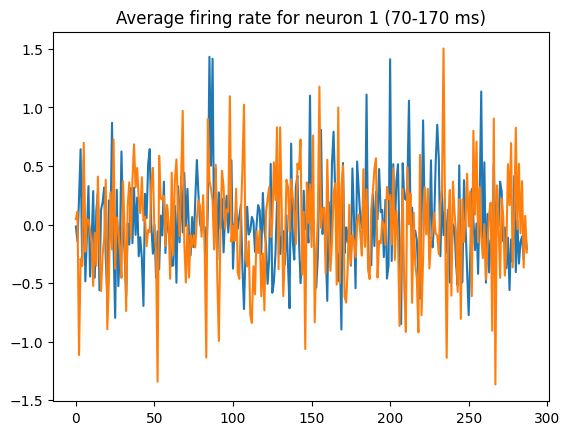

In [20]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(y_val[:,neuron_idx])
plt.plot(y_pred_ridge[:,neuron_idx])

<Figure size 640x480 with 0 Axes>

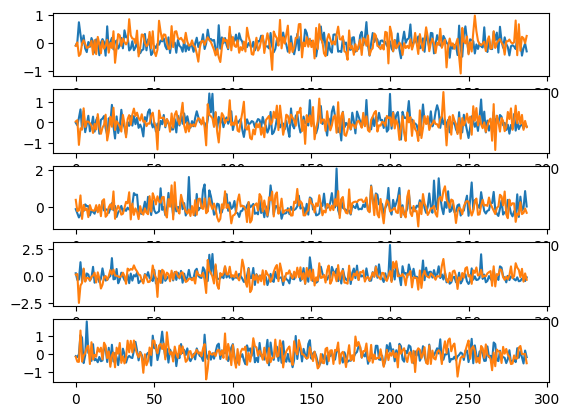

<Figure size 640x480 with 0 Axes>

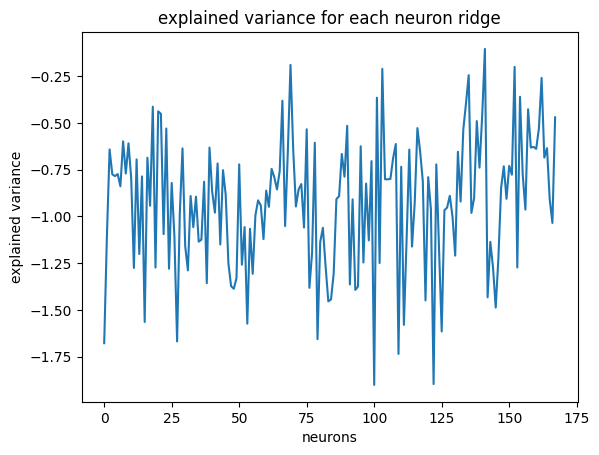

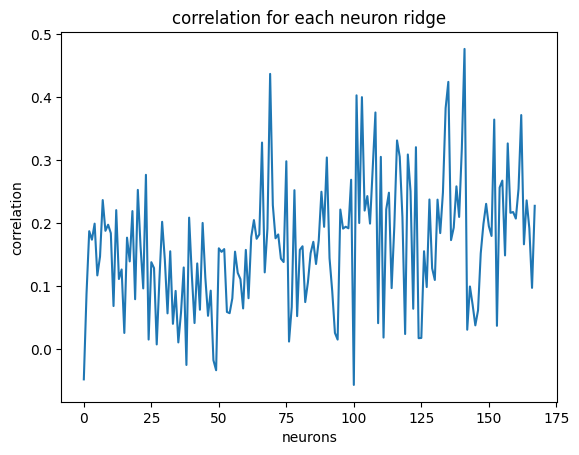

mean of correlation  0.1652828464365293
mean of explained variance  -0.9253271860735757


In [21]:
#evaluate the ridge regression model

corr_ridge,var_ridge,mCorr_ridge,mVar_ridge = evaluation(y_val,y_pred_ridge,"ridge")

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [22]:
## 2: Apply PCA and ridge regression

In [23]:
X_train.shape

(2592, 150528)

In [24]:
#pca
pca = PCA(n_components=1000)

#fit the pca and reduce the data

X_train_reduced = pca.fit_transform(X_train)
#X_train_recovered = pca.inverse_transform(X_train_reduced)

X_val_reduced = pca.transform(X_val)
#X_train_recovered = pca.inverse_transform(X_train_reduced)

In [25]:
X_train_reduced.shape

(2592, 1000)

In [26]:
X_val_reduced.shape

(288, 1000)

In [27]:
# train a ridge regression model on the reduced data

PCA_ridge = linear_model.Ridge()
PCA_ridge.fit(X_train_reduced,y_train)

Ridge()

In [28]:
#prediction

y_pred_pcaridge = PCA_ridge.predict(X_val_reduced)

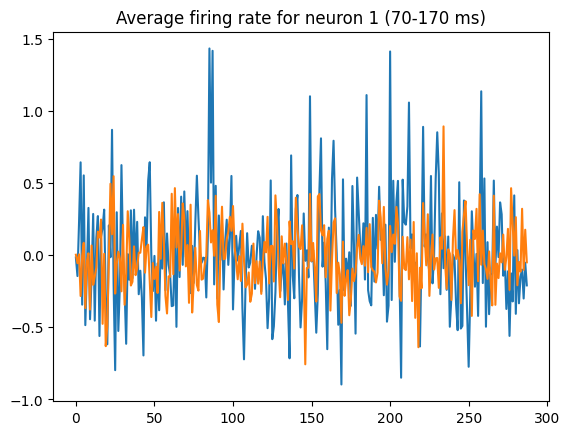

In [29]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(y_val[:,neuron_idx])
plt.plot(y_pred_pcaridge[:,neuron_idx])

<Figure size 640x480 with 0 Axes>

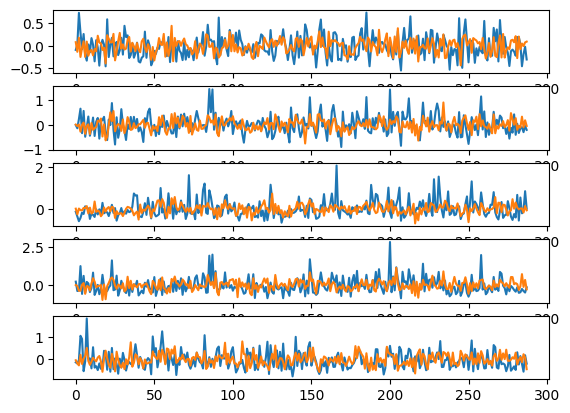

<Figure size 640x480 with 0 Axes>

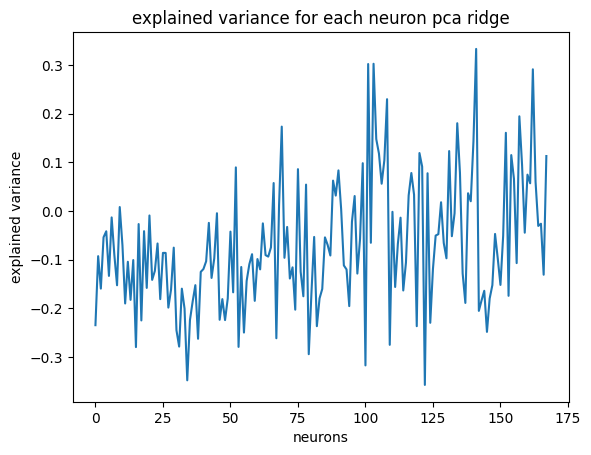

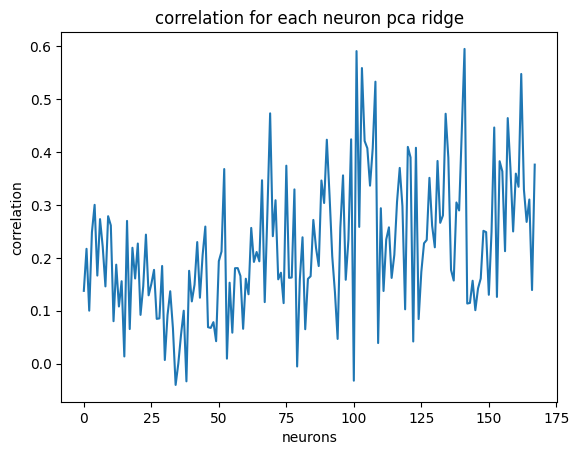

mean of correlation  0.22064027188271776
mean of explained variance  -0.07172998360225133


In [30]:
#evaluate the model

corr_pca,var_pca,mCorr_pca,mVar_pca = evaluation(y_val,y_pred_pcaridge,"pca ridge")

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [31]:
## 3: Apply cross-validation to improve the result

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

In [33]:

#instantiate the set of parameters to tune and the model
alpha_set = [int(x) for x in np.linspace(pow(10, 5),pow(10, 6), num = 100)]

param = {'alpha': alpha_set}

ridge = linear_model.Ridge()

# Instantiate the grid search model
grid_search_ridge = GridSearchCV(estimator = ridge, param_grid = param, cv = 5, n_jobs = -1, verbose = 2)

#we can also use RandomizedSearchCV (especially useful if a lot of parameters to test or for big database
#randomized_search_ridge = RandomizedSearchCV(estimator = ridge, param_distributions = param, cv = 5, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
#we use the reduced dataset with PCA

grid_search_ridge.fit(X_train_reduced, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [100000, 109090, 118181, 127272, 136363,
                                   145454, 154545, 163636, 172727, 181818,
                                   190909, 200000, 209090, 218181, 227272,
                                   236363, 245454, 254545, 263636, 272727,
                                   281818, 290909, 300000, 309090, 318181,
                                   327272, 336363, 345454, 354545, 363636, ...]},
             verbose=2)

In [34]:
#display the result

opt_alpha = grid_search_ridge.best_params_['alpha']
best_grid = grid_search_ridge.best_estimator_
scores = grid_search_ridge.cv_results_["mean_test_score"]
scores_std = grid_search_ridge.cv_results_["std_test_score"]
print("Validations scores are ", scores, "with best score = ", scores.max(), "alpha_opt = ", opt_alpha)

Validations scores are  [0.05536383 0.057824   0.05986987 0.06159082 0.06305276 0.06430516
 0.06538586 0.06632426 0.06714354 0.0678622  0.06849518 0.06905469
 0.06955069 0.06999165 0.07038446 0.07073502 0.07104831 0.07132858
 0.07157949 0.0718042  0.07200543 0.07218556 0.07234667 0.07249058
 0.07261893 0.07273313 0.07283444 0.07292398 0.07300277 0.0730717
 0.07313158 0.07318314 0.07322702 0.07326384 0.07329411 0.07331835
 0.07333698 0.07335041 0.07335902 0.07336314 0.07336308 0.07335913
 0.07335155 0.07334058 0.07332645 0.07330936 0.0732895  0.07326704
 0.07324216 0.073215   0.0731857  0.07315439 0.07312121 0.07308625
 0.07304962 0.07301144 0.07297178 0.07293073 0.07288838 0.0728448
 0.07280007 0.07275424 0.07270739 0.07265957 0.07261084 0.07256125
 0.07251085 0.0724597  0.07240782 0.07235526 0.07230206 0.07224827
 0.0721939  0.07213901 0.07208361 0.07202774 0.07197143 0.0719147
 0.07185758 0.07180009 0.07174226 0.0716841  0.07162565 0.07156691
 0.0715079  0.07144865 0.07138917 0.07132

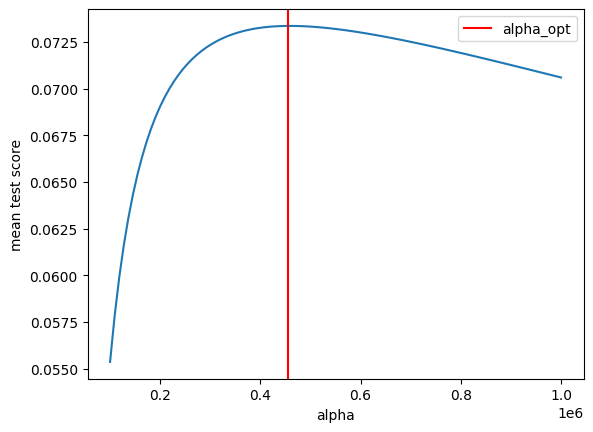

In [35]:
#plot the result

plt.figure()
plt.plot(alpha_set,scores)
plt.axvline(opt_alpha,color = "red",label = "alpha_opt")
plt.legend()
plt.xlabel('alpha')
plt.ylabel('mean test score')

plt.savefig('figure/cross-validation alpha parameter')
plt.show()

In [36]:
#prediction 

predict_spike_cv = grid_search_ridge.best_estimator_.predict(X_val_reduced)

In [37]:
predict_spike_cv.shape

(288, 168)

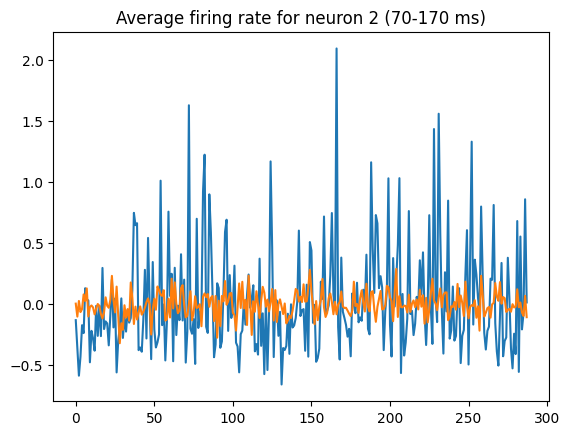

In [38]:
neuron_idx = 2

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(y_val[:,neuron_idx])
plt.plot(predict_spike_cv[:,neuron_idx])

<Figure size 640x480 with 0 Axes>

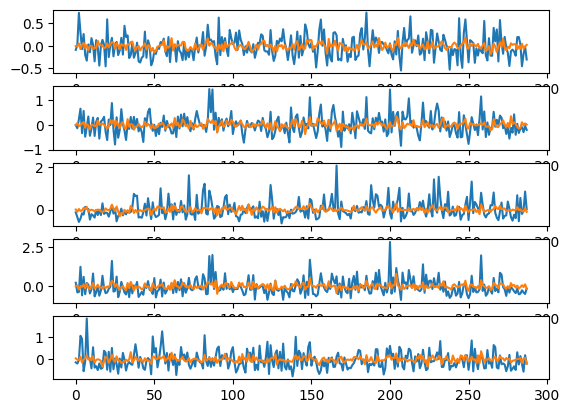

<Figure size 640x480 with 0 Axes>

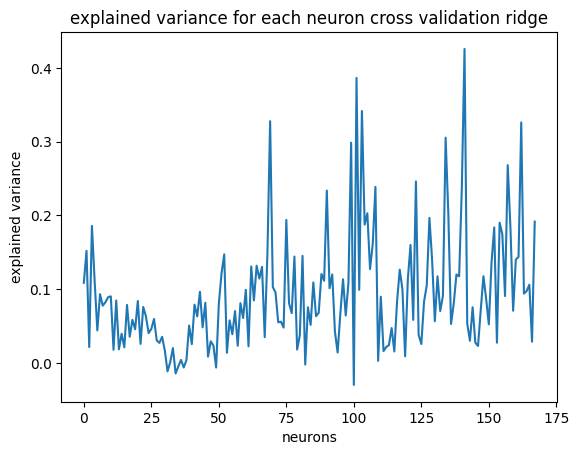

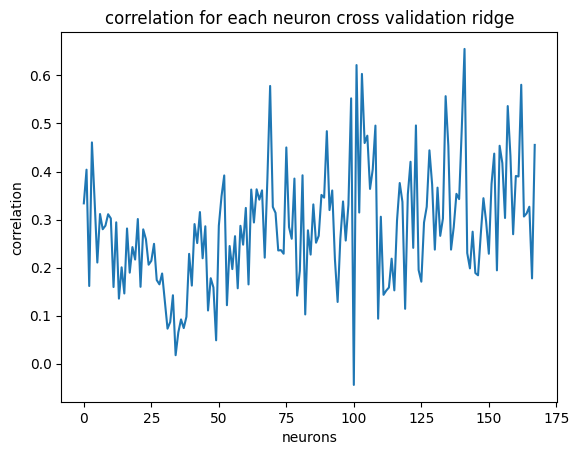

mean of correlation  0.28442222553100877
mean of explained variance  0.09188154942932583


In [39]:
#evaluate the model

corr_cross,var_cross,mCorr_cross,mVar_cross = evaluation(y_val,predict_spike_cv,"cross validation ridge")

## 4: Compare models

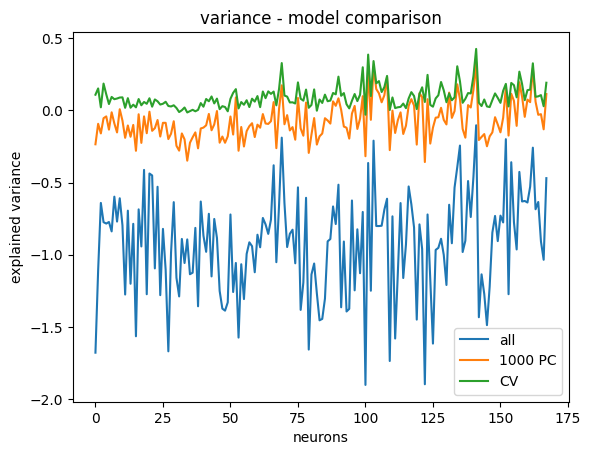

In [40]:
plt.figure()
plt.title('variance - model comparison')
plt.xlabel('neurons')
plt.ylabel("explained variance")
plt.plot(var_ridge)
plt.plot(var_pca)
plt.plot(var_cross)
plt.legend(["all","1000 PC", "CV"])

plt.savefig('figure/variance - model comparison')
plt.show()

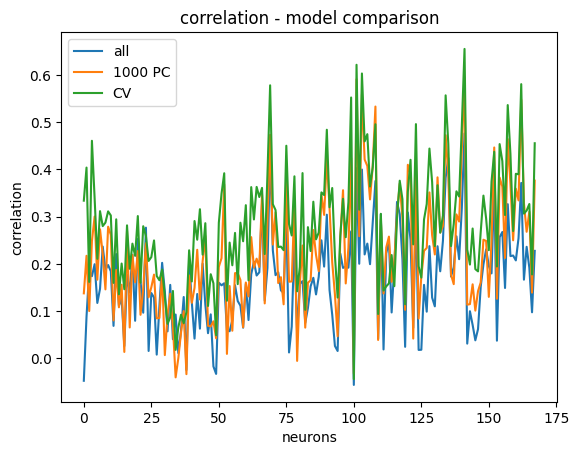

In [41]:
plt.figure()
plt.title('correlation - model comparison')
plt.xlabel('neurons')
plt.ylabel("correlation")
plt.plot(corr_ridge)
plt.plot(corr_pca)
plt.plot(corr_cross)
plt.legend(["all","1000 PC", "CV"])

plt.savefig('figure/correlation - model comparison')
plt.show()

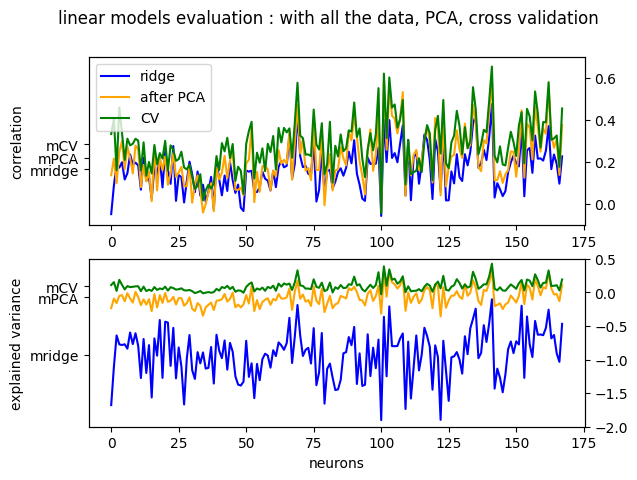

In [42]:
fig, axs = plt.subplots(2)
fig.suptitle('linear models evaluation : with all the data, PCA, cross validation')

axs[0].set_ylim(-0.1,0.7)
#axs[0].set_xlabel('neurons')
axs[0].set_ylabel('correlation')
axs[0].plot(corr_ridge,color = 'blue')
axs[0].plot(corr_pca,color= 'orange')
axs[0].plot(corr_cross,color= 'green')
#axs[0].axhline(mCorr_ridge,color= 'blue')
#axs[0].axhline(mCorr_pca,color= 'orange')
#axs[0].axhline(mCorr_cross,color= 'green')
y = np.array([mCorr_ridge, mCorr_pca,mCorr_cross])
corr = ['mridge', 'mPCA', 'mCV']
axs[0].set_yticks(y, corr)
axs[0].legend(['ridge', 'after PCA', 'CV'])

ax0 = axs[0].twinx()
ax0.set_ylim(-0.1,0.7)

axs[1].set_ylim(-2,0.5)
axs[1].set_xlabel('neurons')
axs[1].set_ylabel("explained variance")
axs[1].plot(var_ridge,color= 'blue')
axs[1].plot(var_pca,color= 'orange')
axs[1].plot(var_cross,color= 'green')
#axs[1].axhline(mVar_ridge,color= 'blue')
#axs[1].axhline(mVar_pca,color= 'orange')
#axs[1].axhline(mVar_cross,color= 'green')
y = np.array([mVar_ridge, mVar_pca,mVar_cross])
corr = ['mridge', 'mPCA', 'mCV']
axs[1].set_yticks(y, corr)

ax1 = axs[1].twinx()
ax1.set_ylim(-2,0.5)

plt.savefig('figure/report model comparison')
plt.show()